In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df= pd.read_csv('/content/df_megr (1).csv')

Identify slow routes by comparing average speeds on different routes


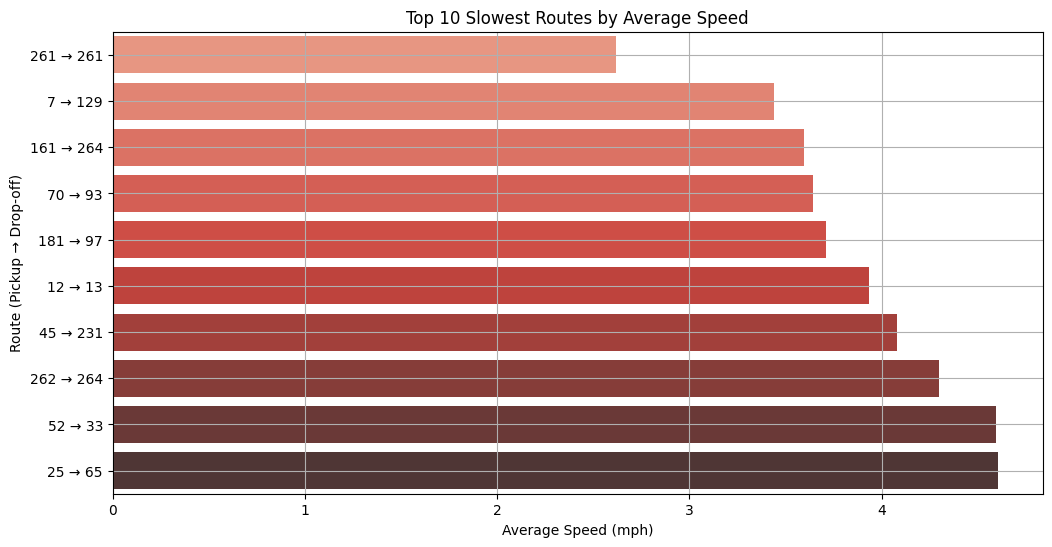

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df['trip_duration_hours'] = df['trip_duration'] / 60

df = df[df['trip_duration_hours'] > 0]

df['trip_speed'] = df['trip_distance'] / df['trip_duration_hours']

df = df[(df['trip_speed'] > 1) & (df['trip_speed'] < 40)]  # Assuming city traffic speeds

route_speeds = df.groupby(['PULocationID', 'DOLocationID'])['trip_speed'].mean().reset_index()
route_speeds.rename(columns={'trip_speed': 'avg_speed_mph'}, inplace=True)

slowest_routes = route_speeds.nsmallest(10, 'avg_speed_mph')

plt.figure(figsize=(12, 6))
sns.barplot(
    x=slowest_routes["avg_speed_mph"],
    y=slowest_routes.apply(lambda x: f"{int(x.PULocationID)} → {int(x.DOLocationID)}", axis=1),
    palette="Reds_d"
)
plt.xlabel("Average Speed (mph)")
plt.ylabel("Route (Pickup → Drop-off)")
plt.title("Top 10 Slowest Routes by Average Speed")
plt.grid(True)
plt.show()




Scale up the number of trips from above to find the actual number of trips


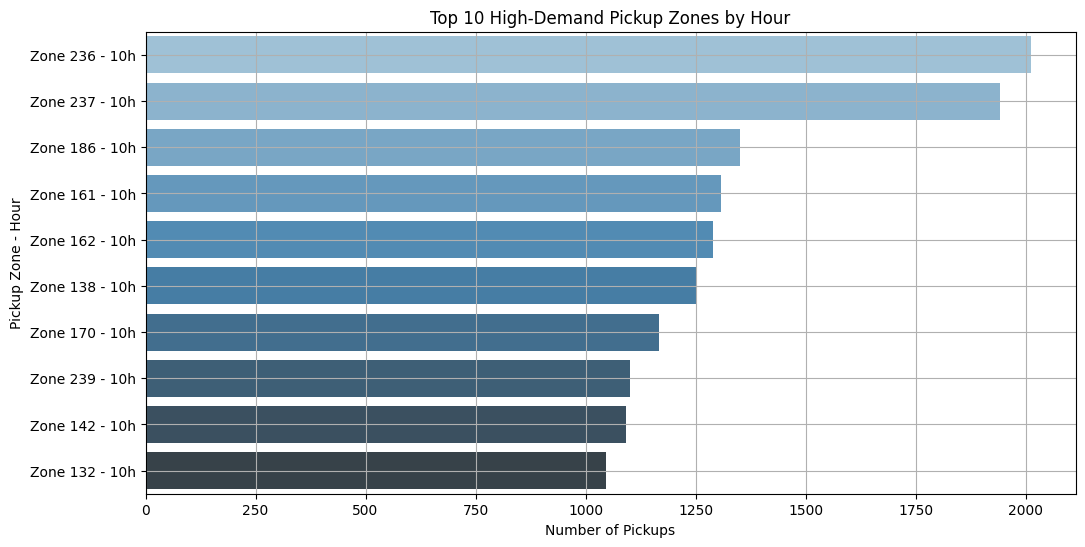

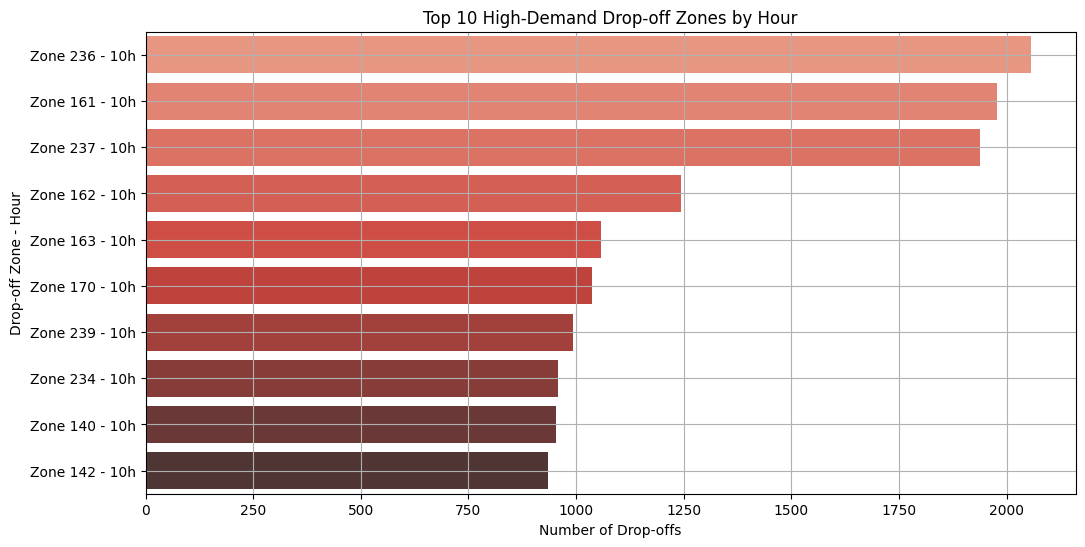

(     PULocationID  pickup_hour  pickup_count
 101           236           10          2013
 102           237           10          1941
 78            186           10          1351
 68            161           10          1308
 69            162           10          1290
 54            138           10          1252
 74            170           10          1166
 104           239           10          1102
 57            142           10          1091
 51            132           10          1047,
      DOLocationID  pickup_hour  dropoff_count
 198           236           10           2057
 132           161           10           1977
 199           237           10           1939
 133           162           10           1243
 134           163           10           1058
 141           170           10           1036
 201           239           10            993
 196           234           10            958
 113           140           10            954
 115           142     

In [12]:
df['pickup_hour'] = pd.to_datetime(df['tpep_pickup_datetime']).dt.hour  # Extract hour from datetime column
pickup_demand = df.groupby(['PULocationID', 'pickup_hour']).size().reset_index(name='pickup_count')

top_pickup_zones = pickup_demand.nlargest(10, 'pickup_count')


dropoff_demand = df.groupby(['DOLocationID', 'pickup_hour']).size().reset_index(name='dropoff_count')

top_dropoff_zones = dropoff_demand.nlargest(10, 'dropoff_count')

pickup_demand = df.groupby(['PULocationID', 'pickup_hour']).size().reset_index(name='pickup_count')

top_pickup_zones = pickup_demand.nlargest(10, 'pickup_count')

dropoff_demand = df.groupby(['DOLocationID', 'pickup_hour']).size().reset_index(name='dropoff_count')

top_dropoff_zones = dropoff_demand.nlargest(10, 'dropoff_count')

plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_pickup_zones["pickup_count"],
    y=top_pickup_zones.apply(lambda x: f"Zone {int(x.PULocationID)} - {int(x.pickup_hour)}h", axis=1),
    palette="Blues_d"
)
plt.xlabel("Number of Pickups")
plt.ylabel("Pickup Zone - Hour")
plt.title("Top 10 High-Demand Pickup Zones by Hour")
plt.grid(True)
plt.show()

# Plot top 10 high-demand drop-off zones
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_dropoff_zones["dropoff_count"],
    y=top_dropoff_zones.apply(lambda x: f"Zone {int(x.DOLocationID)} - {int(x.pickup_hour)}h", axis=1),
    palette="Reds_d"
)
plt.xlabel("Number of Drop-offs")
plt.ylabel("Drop-off Zone - Hour")
plt.title("Top 10 High-Demand Drop-off Zones by Hour")
plt.grid(True)
plt.show()

# Display top 10 pickup and drop-off zones
top_pickup_zones, top_dropoff_zones


Identify the top zones with high traffic during night hours

Compare the fare rates of different vendors in a distance-tiered fashion


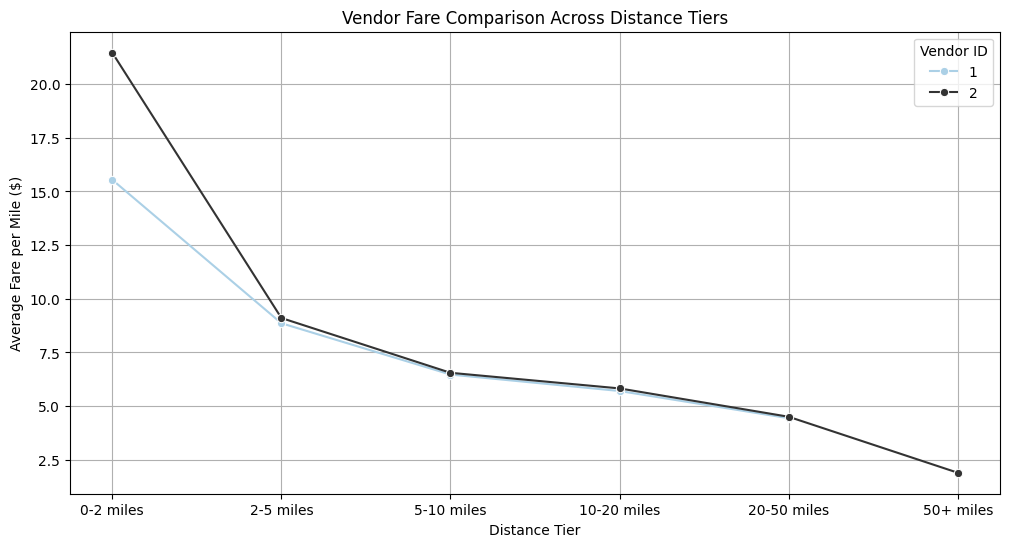

,VendorID,distance_tier,fare_per_mile
0,1,0-2 miles,15.541002
1,1,2-5 miles,8.858512
2,1,5-10 miles,6.468613
3,1,10-20 miles,5.701950
4,1,20-50 miles,4.435958
5,1,50+ miles,NaN
6,2,0-2 miles,21.459695
7,2,2-5 miles,9.102223
8,2,5-10 miles,6.550297
9,2,10-20 miles,5.822956


In [14]:
bins = [0, 2, 5, 10, 20, 50, np.inf]
labels = ["0-2 miles", "2-5 miles", "5-10 miles", "10-20 miles", "20-50 miles", "50+ miles"]
df["distance_tier"] = pd.cut(df["trip_distance"], bins=bins, labels=labels, right=False)

df['fare_per_mile'] = df['total_amount'] / df['trip_distance']  # Calculate fare per mile

fare_per_mile_by_vendor_tier = df.groupby(["VendorID", "distance_tier"])["fare_per_mile"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=fare_per_mile_by_vendor_tier,
    x="distance_tier",
    y="fare_per_mile",
    hue="VendorID",
    marker="o",
    palette="Blues_d"
)
plt.xlabel("Distance Tier")
plt.ylabel("Average Fare per Mile ($)")
plt.title("Vendor Fare Comparison Across Distance Tiers")
plt.grid(True)
plt.legend(title="Vendor ID")
plt.show()

fare_per_mile_by_vendor_tier

Analyse the tip percentages


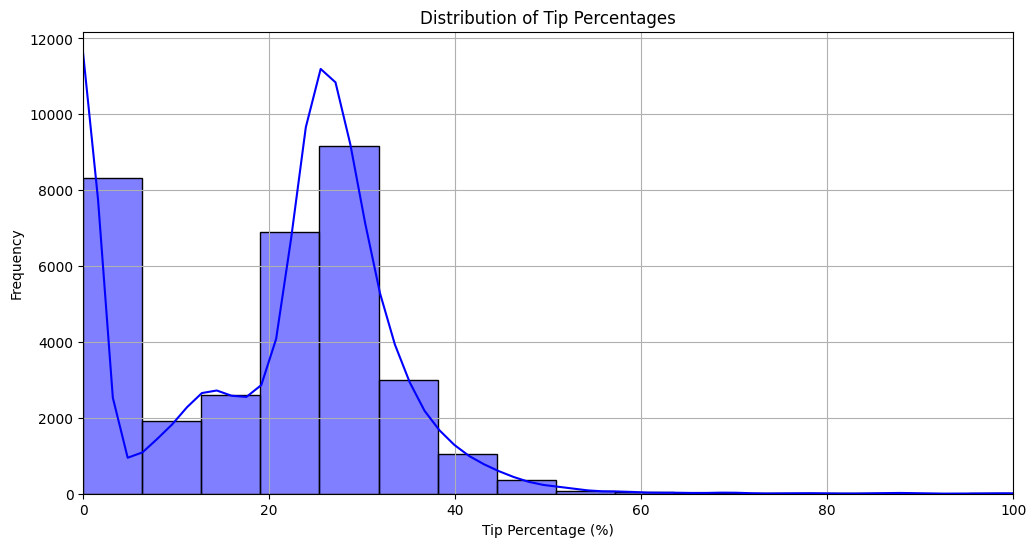

,tip_percentage
count,33528.000000
mean,19.719209
std,14.024625
min,0.000000
25%,6.711409
50%,23.902439
75%,28.602151
max,317.626263


In [15]:
df["tip_percentage"] = (df["tip_amount"] / df["fare_amount"]) * 100

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(subset=["tip_percentage"], inplace=True)

tip_stats = df["tip_percentage"].describe()

plt.figure(figsize=(12, 6))
sns.histplot(df["tip_percentage"], bins=50, kde=True, color="blue")
plt.xlim(0, 100)
plt.xlabel("Tip Percentage (%)")
plt.ylabel("Frequency")
plt.title("Distribution of Tip Percentages")
plt.grid(True)
plt.show()

tip_stats


Analyse the trends in passenger count

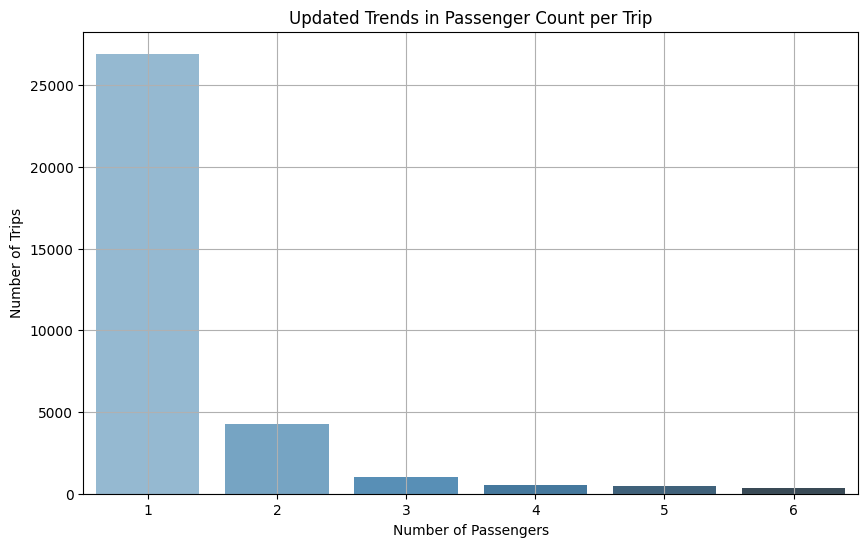

,passenger_count,trip_count
0,1,26934
1,2,4251
2,3,1011
3,4,508
4,5,459
5,6,365


In [16]:
df['passenger_count'] = df['passenger_count'].replace(0, 1)

passenger_trend_updated = df["passenger_count"].value_counts().reset_index()
passenger_trend_updated.columns = ["passenger_count", "trip_count"]
passenger_trend_updated = passenger_trend_updated.sort_values(by="passenger_count")

plt.figure(figsize=(10, 6))
sns.barplot(x=passenger_trend_updated["passenger_count"], y=passenger_trend_updated["trip_count"], palette="Blues_d")
plt.xlabel("Number of Passengers")
plt.ylabel("Number of Trips")
plt.title("Updated Trends in Passenger Count per Trip")
plt.grid(True)
plt.show()

passenger_trend_updated


Analyse the variation of passenger counts across zones


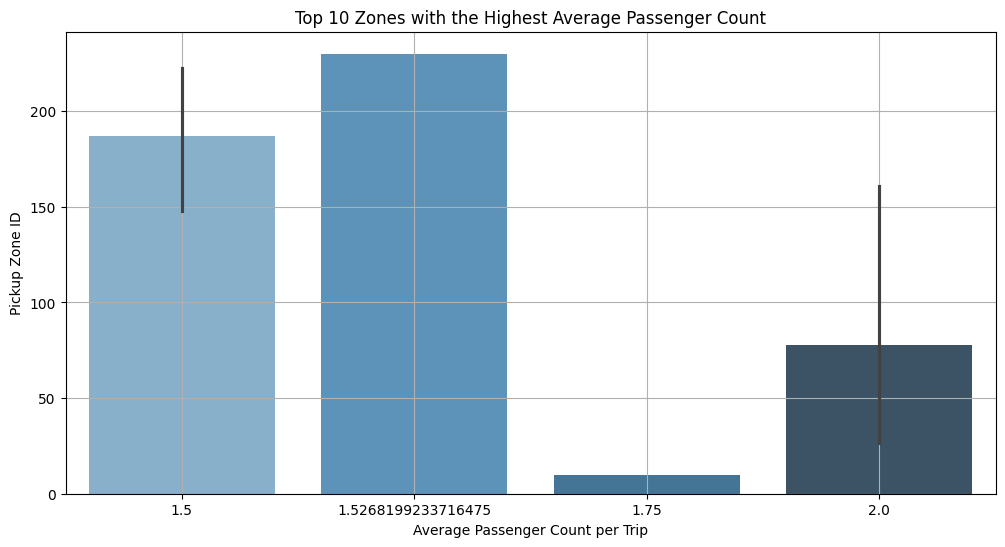

,PULocationID,passenger_count
7,25,2.00000
8,28,2.00000
19,53,2.00000
84,205,2.00000
3,10,1.75000
96,230,1.52682
60,145,1.50000
66,157,1.50000
87,213,1.50000
98,232,1.50000


In [17]:
passenger_by_zone = df.groupby('PULocationID')['passenger_count'].mean().reset_index()

top_passenger_zones = passenger_by_zone.nlargest(10, 'passenger_count')

plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_passenger_zones["passenger_count"],
    y=top_passenger_zones["PULocationID"].astype(int),
    palette="Blues_d"
)
plt.xlabel("Average Passenger Count per Trip")
plt.ylabel("Pickup Zone ID")
plt.title("Top 10 Zones with the Highest Average Passenger Count")
plt.grid(True)
plt.show()

top_passenger_zones


Analyse the pickup/dropoff zones or times when extra charges are applied more frequently.

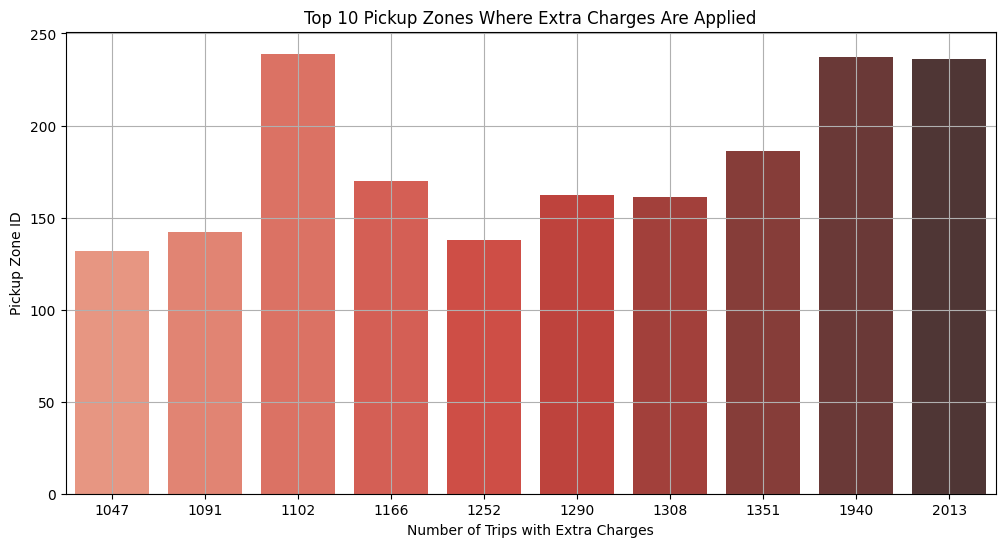

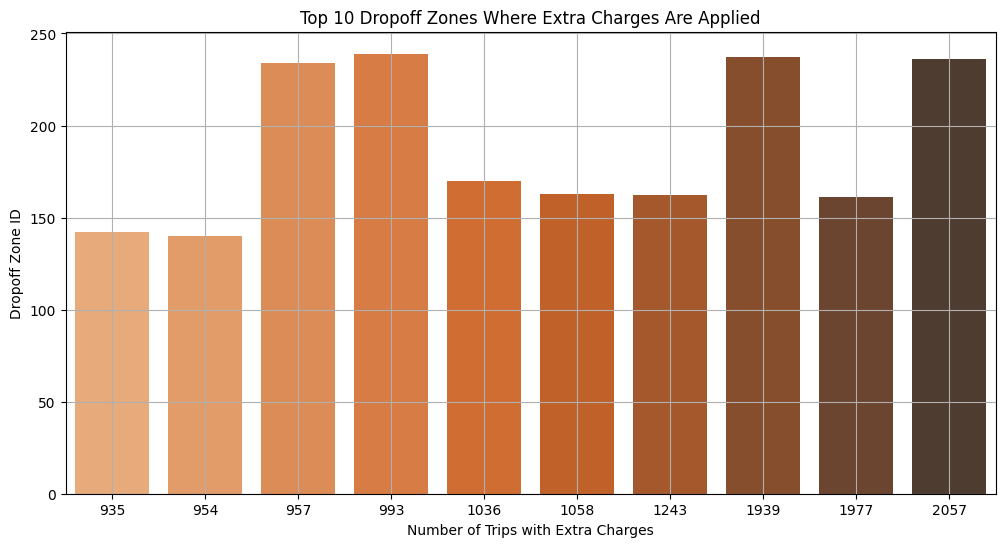

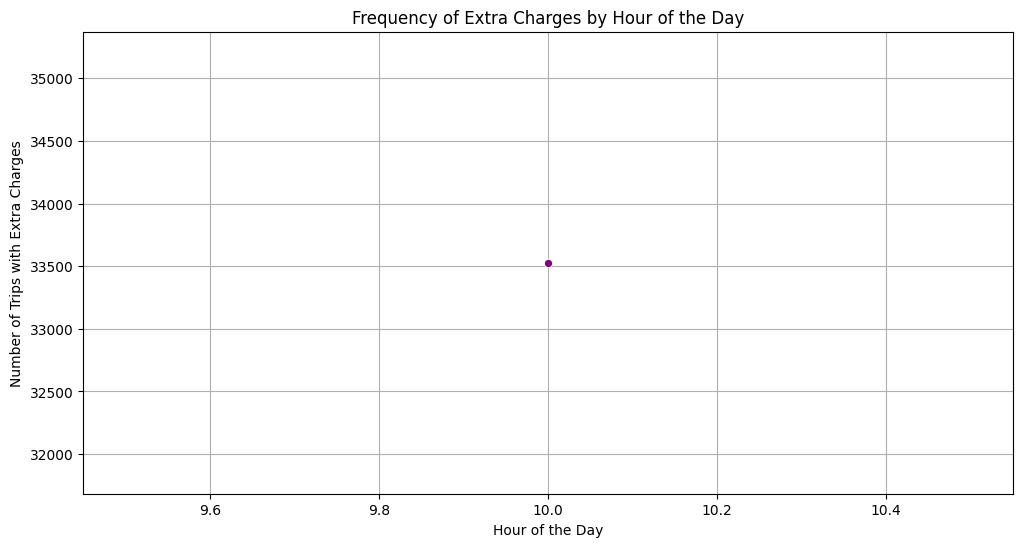

(     PULocationID  extra_charges
 101           236           2013
 102           237           1940
 78            186           1351
 68            161           1308
 69            162           1290
 54            138           1252
 74            170           1166
 104           239           1102
 57            142           1091
 51            132           1047,
      DOLocationID  extra_charges
 198           236           2057
 132           161           1977
 199           237           1939
 133           162           1243
 134           163           1058
 141           170           1036
 201           239            993
 196           234            957
 113           140            954
 115           142            935,
    pickup_hour  extra_charges
 0           10          33528)

In [18]:
df["extra_charges"] = df["improvement_surcharge"] + df["congestion_surcharge"] + df["combined_airport_fee"]

df_extra = df[df["extra_charges"] > 0]

extra_by_pickup_zone = df_extra.groupby("PULocationID")["extra_charges"].count().reset_index().nlargest(10, "extra_charges")

extra_by_dropoff_zone = df_extra.groupby("DOLocationID")["extra_charges"].count().reset_index().nlargest(10, "extra_charges")

extra_by_hour = df_extra.groupby("pickup_hour")["extra_charges"].count().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(
    x=extra_by_pickup_zone["extra_charges"],
    y=extra_by_pickup_zone["PULocationID"].astype(int),
    palette="Reds_d"
)
plt.xlabel("Number of Trips with Extra Charges")
plt.ylabel("Pickup Zone ID")
plt.title("Top 10 Pickup Zones Where Extra Charges Are Applied")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(
    x=extra_by_dropoff_zone["extra_charges"],
    y=extra_by_dropoff_zone["DOLocationID"].astype(int),
    palette="Oranges_d"
)
plt.xlabel("Number of Trips with Extra Charges")
plt.ylabel("Dropoff Zone ID")
plt.title("Top 10 Dropoff Zones Where Extra Charges Are Applied")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(
    x=extra_by_hour["pickup_hour"],
    y=extra_by_hour["extra_charges"],
    marker="o",
    color="purple"
)
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Trips with Extra Charges")
plt.title("Frequency of Extra Charges by Hour of the Day")
plt.grid(True)
plt.show()

extra_by_pickup_zone, extra_by_dropoff_zone, extra_by_hour
